# PSD

* **author**: steeve.laquitaine@epfl.ch

* **Figure**: Figure 2G-I

* **Execution duration:** : 10 mins for 10 min recordings

* **Method**: PSD for first 10 minutes of recording. We will analyse the first 10 minutes as PSD is stable across time (compared with 40 min).
    * `Marques` (aligned with cortical column)
        * rat cortex S1
        * 384ch 
        * 30.0kHz
        * 20.25 min
        * "Spontaneous activity" (Only anesthetized condition)
    * `Horvath`:
        * rat cortex S1
        * 128ch
        * 20.0kHz
        * Horvath in vivo probe 1:
            * duration: 3606.552 (~60 mins)
        * Horvath in vivo probe 2:
            * duration: 3688.668 secs (~61 mins)
        * Horvath in vivo probe 3:
            * duration: 3603.096 secs (~60 mins)  
        * "Spontaneous activity" (Only anesthetized condition)    
    * Welch method
        * 1Hz resolution

### Setup

1. Activate `spikeinterf..` venv

2. precompute data with: $ sbatch cluster/validation/main/marques/psd_buttw_noise_fitd_gain_ftd_10perc_less_raw_welch.sbatch

In [12]:
# import libs
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

import os
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import spikeinterface as si
import copy

# move to PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/"
os.chdir(PROJ_PATH)

from src.nodes.utils import get_config
from src.nodes.validation import power

matplotlib.rcParams['agg.path.chunksize'] = 10000

# SETUP PARAMETERS
SFREQ_HV = 20000          # sampling frequency
SFREQ_HS = 20000        # sampling frequency
SFREQ_MV = 30000          # sampling frequency
SFREQ_MS = 40000        # sampling frequency
SFREQ_B = 32000

# SETUP DATASET COMFIG
# marques
cfg_mv, _ = get_config("vivo_marques", "c26").values()
RAW_PATH_mv = cfg_mv["probe_wiring"]["output"]
PREP_PATH_mv = cfg_mv["preprocessing"]["output"]["trace_file_path"]

# horvath
cfg_hv, _ = get_config("vivo_horvath", "probe_2").values()
RAW_PATH_hv = cfg_hv["probe_wiring"]["output"]
PREP_PATH_hv = cfg_hv["preprocessing"]["output"]["trace_file_path"]

# marques silico 
cfg_ms, _ = get_config(
    "silico_neuropixels", "concatenated"
).values()
RAW_PATH_ms = cfg_ms["probe_wiring"]["output"]
PREP_PATH_ms = cfg_ms["preprocessing"]["output"]["trace_file_path"]

# horvath silico 
cfg_hs, _ = get_config(
    "silico_horvath", "concatenated/probe_2"
).values()
RAW_PATH_hs = cfg_hs["probe_wiring"]["output"]
PREP_PATH_hs = cfg_hs["preprocessing"]["output"]["trace_file_path"]

# Buccino with fitted gain for layer 5
data_conf_b, _ = get_config("buccino_2020", "2020").values()
RAW_PATH_GAIN_FTD_B = data_conf_b["analyses"]["psd"]["10m"]["raw_gain_ftd"]
PREP_PATH_GAIN_FTD_B = data_conf_b["analyses"]["psd"]["10m"]["prep_gain_ftd"]

# FIGURE SETTINGS
#FIG_SIZE = (8.5, 4)
#FIG_SIZE = (14, 4)
FIG_SIZE = (1.05, 1.05)
COLOR_HV = [0.75, 0.75, 0.75] # light
COLOR_MV = [0.4, 0.4, 0.4]
COLOR_HS = [0.9, 0.64, 0.65] # light
COLOR_MS = [0.9, 0.14, 0.15]

plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6  # 5-7 with Nature neuroscience as reference
plt.rcParams["lines.linewidth"] = 0.3
plt.rcParams["axes.linewidth"] = 0.3 #1
plt.rcParams["axes.spines.top"] = False
#plt.rcParams["axes.spines.right"] = False
plt.rcParams["xtick.major.width"] = 0.3 #0.8 #* 1.3
plt.rcParams["xtick.minor.width"] = 0.3 #0.8 #* 1.3
plt.rcParams["ytick.major.width"] = 0.3 #0.8 #* 1.3
plt.rcParams["ytick.minor.width"] = 0.3 #0.8 #* 1.3
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1

N_MAJOR_TICKS = 4
N_MINOR_TICKS = 12
#YLIM = [1e-7, 1e8]
savefig_cfg = {"transparent":True, "dpi":300}
legend_cfg = {"frameon": False, "handletextpad": 0.1}
tight_layout_cfg = {"pad": 0.5}
LG_FRAMEON = False              # no legend frame

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2024-06-17 10:59:22,176 - root - utils.py - get_config - INFO - Reading experiment config.
2024-06-17 10:59:22,196 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-06-17 10:59:22,198 - root - utils.py - get_config - INFO - Reading experiment config.
2024-06-17 10:59:22,207 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-06-17 10:59:22,208 - root - utils.py - get_config - INFO - Reading experiment config.
2024-06-17 10:59:22,287 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-06-17 10:59:22,288 - root - utils.py - get_config - INFO - Reading experiment config.
2024-06-17 10:59:22,303 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-06-17 10:59:22,304 - root - utils.py - get_config - INFO - Reading experiment config.
2024-06-17 10:59:22,326 - root - utils.py - get_config - INFO - R

### Load dataset

In [2]:
# Load traces
# horvath
RawHV = si.load_extractor(RAW_PATH_hv)
RawHS = si.load_extractor(RAW_PATH_hs)
PrepHV = si.load_extractor(PREP_PATH_hv)
PrepHS = si.load_extractor(PREP_PATH_hs)

# marques
RawMV = si.load_extractor(RAW_PATH_mv)
RawMS = si.load_extractor(RAW_PATH_ms)
PrepMV = si.load_extractor(PREP_PATH_mv)
PrepMS = si.load_extractor(PREP_PATH_ms)

# select first 10 minutes
# horvath
RawHV = RawHV.frame_slice(start_frame=0, end_frame=SFREQ_HV * 10 * 60)
RawHS = RawHS.frame_slice(start_frame=0, end_frame=SFREQ_HS * 10 * 60)
PrepHV = PrepHV.frame_slice(start_frame=0, end_frame=SFREQ_HV * 10 * 60)
PrepHS = PrepHS.frame_slice(start_frame=0, end_frame=SFREQ_HS * 10 * 60)
# marques
RawMV = RawMV.frame_slice(start_frame=0, end_frame=SFREQ_MV * 10 * 60)
RawMS = RawMS.frame_slice(start_frame=0, end_frame=SFREQ_MS * 10 * 60)
PrepMV = PrepMV.frame_slice(start_frame=0, end_frame=SFREQ_MV * 10 * 60)
PrepMS = PrepMS.frame_slice(start_frame=0, end_frame=SFREQ_MS * 10 * 60)

# traces
raw_hv, pre_hv, raw_mv, pre_mv, raw_hs, pre_hs, raw_ms, pre_ms = (
    power.load_saved_traces_in_ctx()
)
# psds
(
    psd_raw_hv,
    psd_pre_hv,
    psd_raw_mv,
    psd_pre_mv,
    psd_raw_hs,
    psd_pre_hs,
    psd_raw_ms,
    psd_pre_ms,
) = power.load_psd_results()

# psd Buccino (layer 5)
psd_raw_b = np.load(RAW_PATH_GAIN_FTD_B, allow_pickle=True).item()
psd_pre_b = np.load(PREP_PATH_GAIN_FTD_B, allow_pickle=True).item()

# sanity check
assert RawHS.get_total_duration() == 10 * 60, "not 10 min"
assert RawHV.get_total_duration() == 10 * 60, "not 10 min"
assert RawMV.get_total_duration() == 10 * 60, "not 10 min"
assert RawMS.get_total_duration() == 10 * 60, "not 10 min"
assert PrepHS.get_total_duration() == 10 * 60, "not 10 min"
assert PrepHV.get_total_duration() == 10 * 60, "not 10 min"
assert PrepMV.get_total_duration() == 10 * 60, "not 10 min"
assert PrepMS.get_total_duration() == 10 * 60, "not 10 min"

# unit-test
assert psd_raw_hv["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_raw_hs["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_raw_ms["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_raw_mv["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_hv["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_hs["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_ms["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_mv["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_raw_b["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_b["freq"][1] == 1.0, "psd resolution should be 1Hz"

### Utils

In [14]:
# def load_saved_traces_in_ctx():

#     # vivo marques
#     raw_traces_m = np.load(
#         "/gpfs/bbp.cscs.ch/project/proj85/laquitai/spikebias_paper/dataeng/1_vivo/marques/campaign/c26_fixed/traces_in_ctx_10m_noise_fitd.npy"
#     )
#     prep_traces_m = np.load(
#         "/gpfs/bbp.cscs.ch/project/proj85/laquitai/spikebias_paper/preprocessed/1_vivo/marques/campaign/c26_fixed/traces_in_ctx_10m_noise_fitd.npy"
#     )

#     # vivo horvath
#     raw_traces_h = np.load(
#         "/gpfs/bbp.cscs.ch/project/proj85/laquitai/spikebias_paper/dataeng/1_vivo/horvath/probe_2/recording/traces_in_ctx_10m.npy"
#     )
#     prep_traces_h = np.load(
#         "/gpfs/bbp.cscs.ch/project/proj85/laquitai/spikebias_paper/preprocessed/1_vivo/horvath/probe_2/recording/traces_in_ctx_10m.npy"
#     )
#     return raw_traces_m, prep_traces_m, raw_traces_h, prep_traces_h


# def load_psd_results():

#     # vivo marques
#     out_raw_m = np.load(
#         "/gpfs/bbp.cscs.ch/project/proj85/laquitai/spikebias_paper/realism/1_vivo/marques/c26_fixed/postpro/full_raw_power_welch_10m.npy",
#         allow_pickle=True,
#     )
#     out_raw_m = out_raw_m.item()

#     out_prep_m = np.load(
#         "/gpfs/bbp.cscs.ch/project/proj85/laquitai/spikebias_paper/realism/1_vivo/marques/c26_fixed/postpro/full_prep_buttw_power_welch_10m.npy",
#         allow_pickle=True,
#     )
#     out_prep_m = out_prep_m.item()

#     # vivo horvath
#     out_raw_h = np.load(
#         "/gpfs/bbp.cscs.ch/project/proj85/laquitai/spikebias_paper/postprocessing/vivo/horvath/probe_2/postpro/realism/lfp/full_raw_power_welch_10m.npy",
#         allow_pickle=True,
#     )
#     out_raw_h = out_raw_h.item()

#     out_prep_h = np.load(
#         "/gpfs/bbp.cscs.ch/project/proj85/laquitai/spikebias_paper/postprocessing/vivo/horvath/probe_2/postpro/realism/lfp/full_prep_buttw_power_welch_10m.npy",
#         allow_pickle=True,
#     )
#     out_prep_h = out_prep_h.item()
#     return out_raw_m, out_prep_m, out_raw_h, out_prep_h


# def get_psd_plot_mean_and_ci(out_raw_vivo, out_raw_sili, out_prep_vivo, out_prep_sili):
#     # (11s) average over sites
#     psd_mean_raw_vivo = np.median(out_raw_vivo["power"], axis=0)
#     psd_mean_raw_sili = np.median(out_raw_sili["power"], axis=0)
#     psd_mean_prep_vivo = np.median(out_prep_vivo["power"], axis=0)
#     psd_mean_prep_sili = np.median(out_prep_sili["power"], axis=0)

#     # confidence intervals
#     # vivo
#     n_samples = out_raw_vivo["power"].shape[0]
#     ci_raw_vivo = 1.96 * np.std(out_raw_vivo["power"], axis=0) / np.sqrt(n_samples)
#     ci_prep_vivo = 1.96 * np.std(out_prep_vivo["power"], axis=0) / np.sqrt(n_samples)
#     # sili
#     n_samples = out_raw_sili["power"].shape[0]
#     ci_raw_sili = 1.96 * np.std(out_raw_sili["power"], axis=0) / np.sqrt(n_samples)
#     ci_prep_sili = 1.96 * np.std(out_prep_sili["power"], axis=0) / np.sqrt(n_samples)

#     return (
#         psd_mean_raw_vivo,
#         psd_mean_raw_sili,
#         psd_mean_prep_vivo,
#         psd_mean_prep_sili,
#         ci_raw_vivo,
#         ci_prep_vivo,
#         ci_raw_sili,
#         ci_prep_sili,
#     )


# def get_psd_plot_mean_and_ci_for_layer(
#     layer: str,
#     lyrs_v: list,
#     lyrs_s: list,
#     out_raw_vivo: dict,
#     out_raw_sili: dict,
#     out_prep_vivo: dict,
#     out_prep_sili: dict,
# ):
#     # get sites in layer
#     power_v = out_raw_vivo["power"][lyrs_v == layer, :]
#     power_s = out_raw_sili["power"][lyrs_s == layer, :]
#     pre_power_v = out_prep_vivo["power"][lyrs_v == layer, :]
#     pre_power_s = out_prep_sili["power"][lyrs_s == layer, :]

#     # (11s) average over sites
#     psd_mean_raw_vivo = np.median(power_v, axis=0)
#     psd_mean_raw_sili = np.median(power_s, axis=0)
#     psd_mean_prep_vivo = np.median(pre_power_v, axis=0)
#     psd_mean_prep_sili = np.median(pre_power_s, axis=0)

#     # confidence intervals
#     # vivo
#     n_samples = power_v.shape[0]
#     ci_raw_vivo = 1.96 * np.std(power_v, axis=0) / np.sqrt(n_samples)
#     ci_prep_vivo = 1.96 * np.std(pre_power_v, axis=0) / np.sqrt(n_samples)

#     # sili
#     n_samples = power_s.shape[0]
#     ci_raw_sili = 1.96 * np.std(power_s, axis=0) / np.sqrt(n_samples)
#     ci_prep_sili = 1.96 * np.std(pre_power_s, axis=0) / np.sqrt(n_samples)

#     return (
#         psd_mean_raw_vivo,
#         psd_mean_raw_sili,
#         psd_mean_prep_vivo,
#         psd_mean_prep_sili,
#         ci_raw_vivo,
#         ci_raw_sili,
#         ci_prep_vivo,
#         ci_prep_sili,
#         out_raw_vivo["freq"],
#         out_raw_sili["freq"],
#         out_prep_vivo["freq"],
#         out_prep_sili["freq"],
#     )


# def get_psd_plot_mean_and_ci_for_layer_5(
#     lyrs_v: list,
#     lyrs_s: list,
#     out_raw_v: dict,
#     out_raw_s: dict,
#     out_raw_b: dict,
#     out_prep_v: dict,
#     out_prep_s: dict,
#     out_prep_b: dict,
# ):

#     # get sites in layer
#     power_v = out_raw_v["power"][lyrs_v == "L5", :]
#     power_s = out_raw_s["power"][lyrs_s == "L5", :]
#     power_b = out_raw_b["power"]
#     pre_power_v = out_prep_v["power"][lyrs_v == "L5", :]
#     pre_power_s = out_prep_s["power"][lyrs_s == "L5", :]
#     pre_power_b = out_prep_b["power"]

#     # (11s) average over sites
#     psd_mean_raw_vivo = np.median(power_v, axis=0)
#     psd_mean_raw_sili = np.median(power_s, axis=0)
#     psd_mean_raw_b = np.median(power_b, axis=0)
#     psd_mean_prep_vivo = np.median(pre_power_v, axis=0)
#     psd_mean_prep_sili = np.median(pre_power_s, axis=0)
#     psd_mean_prep_b = np.median(pre_power_b, axis=0)

#     # confidence intervals
#     # vivo
#     n_samples = power_v.shape[0]
#     ci_raw_vivo = 1.96 * np.std(power_v, axis=0) / np.sqrt(n_samples)
#     ci_prep_vivo = 1.96 * np.std(pre_power_v, axis=0) / np.sqrt(n_samples)

#     # sili
#     n_samples = power_s.shape[0]
#     ci_raw_sili = 1.96 * np.std(power_s, axis=0) / np.sqrt(n_samples)
#     ci_prep_sili = 1.96 * np.std(pre_power_s, axis=0) / np.sqrt(n_samples)

#     # buccino
#     n_samples = power_b.shape[0]
#     ci_raw_b = 1.96 * np.std(power_b, axis=0) / np.sqrt(n_samples)
#     ci_prep_b = 1.96 * np.std(pre_power_b, axis=0) / np.sqrt(n_samples)

#     return (
#         psd_mean_raw_vivo,
#         psd_mean_raw_sili,
#         psd_mean_raw_b,
#         psd_mean_prep_vivo,
#         psd_mean_prep_sili,
#         psd_mean_prep_b,
#         ci_raw_vivo,
#         ci_raw_sili,
#         ci_raw_b,
#         ci_prep_vivo,
#         ci_prep_sili,
#         ci_prep_b,
#         out_raw_v["freq"],
#         out_raw_s["freq"],
#         out_raw_b["freq"],
#         out_prep_v["freq"],
#         out_prep_s["freq"],
#         out_prep_b["freq"],
#     )


# def plot_for_layer(
#     psd_mean_raw_vivo,
#     psd_mean_raw_sili,
#     psd_mean_prep_vivo,
#     psd_mean_prep_sili,
#     ci_raw_vivo,
#     ci_prep_vivo,
#     ci_raw_sili,
#     ci_prep_sili,
#     freq_raw_v,
#     freq_raw_s,
#     freq_prep_v,
#     freq_prep_s,
#     out_raw_vivo,
#     out_raw_sili,
#     out_prep_vivo,
#     out_prep_sili,
#     site_layers_vivo,
#     site_layers_sili,
#     layer,
# ):
#     """plot power spectrum density for the
#     specified layer

#     Args:
#         layer (str): layer "L1", "L2_3", "L4", "L5", "L6"
#         site_layers_sili (list): layers of each in silico sites
#         site_layers_vivo (list): layers of each in vivo sites
#         out_raw_vivo (dict): _description_
#         out_raw_sili (dict): _description_
#     """

#     YLIM_R = [0, 0.01]
#     YLIM_P = [0, 0.005]
#     N_MAJOR_TICKS = 4
#     SIZE = 3
#     ALPHA = 0.7
#     fig, axes = plt.subplots(1, 3, figsize=FIG_SIZE)

#     # Raw panel --------------------------------

#     # VIVO
#     axes[0].plot(
#         freq_raw_v,
#         psd_mean_raw_vivo,
#         linestyle="none",
#         marker="o",
#         markersize=SIZE,
#         color=COLOR_VIVO,
#         label="vivo",
#         rasterized=True,  # cheaper
#     )
#     axes[0].plot(
#         freq_raw_s,
#         psd_mean_raw_sili,
#         linestyle="none",
#         marker="o",
#         markersize=SIZE,
#         color=COLOR_SILI,
#         label="sili",
#         rasterized=True,  # cheaper
#     )

#     # confidence interval
#     axes[0].fill_between(
#         freq_raw_v,
#         (psd_mean_raw_vivo - ci_raw_vivo),
#         (psd_mean_raw_vivo + ci_raw_vivo),
#         color=COLOR_VIVO,
#         linewidth=0,
#         alpha=ALPHA,
#         rasterized=True,
#     )
#     axes[0].fill_between(
#         freq_raw_s,
#         (psd_mean_raw_sili - ci_raw_sili),
#         (psd_mean_raw_sili + ci_raw_sili),
#         color=COLOR_SILI,
#         linewidth=0,
#         alpha=ALPHA,
#         rasterized=True,
#     )

#     # legend
#     axes[0].set_xlabel("Frequency (Hz)")
#     axes[0].set_xlabel("")
#     axes[0].set_xscale("log")
#     axes[0].spines[["right", "top"]].set_visible(False)
#     axes[0].set_ylim(YLIM_R)
#     axes[0].set_xlim([-1, SFREQ_SILICO / 2])
#     axes[0].tick_params(axis="x", which="minor", colors="black")
#     axes[0].tick_params(axis="x", which="major", colors="black")

#     # show minor ticks
#     locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
#     locmin = matplotlib.ticker.LogLocator(
#         base=10.0,
#         subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
#         numticks=N_MINOR_TICKS,
#     )
#     axes[0].tick_params(which="both")
#     axes[0].xaxis.set_major_locator(locmaj)
#     axes[0].xaxis.set_minor_locator(locmin)
#     axes[0].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

#     # disconnect axes (R style)
#     axes[0].spines["bottom"].set_position(("axes", -0.05))
#     axes[0].yaxis.set_ticks_position("left")
#     axes[0].spines["left"].set_position(("axes", -0.05))
#     axes[0].set_ylim(YLIM_R)
#     axes[0].set_xlim([0, SFREQ_SILICO / 2])

#     # Fit panel ************************************************************

#     # get sites in layer
#     out_raw_vivo2 = copy.copy(out_raw_vivo)
#     out_raw_sili2 = copy.copy(out_raw_sili)
#     out_raw_vivo2["power"] = out_raw_vivo2["power"][site_layers_vivo == layer, :]
#     out_raw_sili2["power"] = out_raw_sili2["power"][site_layers_sili == layer, :]

#     # plot
#     plot_fits_all(axes[1], out_raw_vivo2, out_raw_sili2, pm)

#     # Preprocessing ************************************************************

#     # VIVO
#     axes[2].plot(
#         freq_prep_v,
#         psd_mean_prep_vivo,
#         linestyle="none",
#         marker="o",
#         markersize=SIZE,
#         color=COLOR_VIVO,
#         label="vivo",
#         rasterized=True,  # cheaper
#     )
#     axes[2].plot(
#         freq_prep_s,
#         psd_mean_prep_sili,
#         color=COLOR_SILI,
#         label="silico",
#         marker="o",
#         markersize=SIZE,
#         rasterized=True,  # cheaper
#     )

#     # legend
#     # axes[1].set_xlabel("Frequency (Hz)")
#     axes[2].set_xlabel("")
#     axes[2].set_xscale("log")
#     axes[2].spines[["right", "top"]].set_visible(False)
#     axes[2].set_ylim(YLIM_P)
#     axes[2].set_xlim([-1, SFREQ_SILICO / 2])
#     axes[2].tick_params(axis="x", which="minor", colors="black")
#     axes[2].tick_params(axis="x", which="major", colors="black")

#     # show minor ticks
#     locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
#     locmin = matplotlib.ticker.LogLocator(
#         base=10.0,
#         subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
#         numticks=N_MINOR_TICKS,
#     )
#     axes[2].tick_params(which="both")
#     axes[2].xaxis.set_major_locator(locmaj)
#     axes[2].xaxis.set_minor_locator(locmin)
#     axes[2].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

#     # disconnect axes (R style)
#     axes[2].spines["bottom"].set_position(("axes", -0.05))
#     axes[2].yaxis.set_ticks_position("left")
#     axes[2].spines["left"].set_position(("axes", -0.05))
#     axes[2].set_ylim(YLIM_P)
#     axes[2].set_xlim([0, SFREQ_SILICO / 2])

#     fig.tight_layout(**tight_layout_cfg)
#     return axes


# def plot_for_layer_5(
#     psd_mean_raw_vivo,
#     psd_mean_raw_sili,
#     psd_mean_raw_b,
#     psd_mean_prep_vivo,
#     psd_mean_prep_sili,
#     psd_mean_prep_b,
#     ci_raw_vivo,
#     ci_raw_sili,
#     ci_raw_b,
#     ci_prep_vivo,
#     ci_prep_sili,
#     ci_prep_b,
#     freq_raw_v,
#     freq_raw_s,
#     freq_raw_b,
#     freq_prep_v,
#     freq_prep_s,
#     freq_prep_b,
#     out_raw_vivo,
#     out_raw_sili,
#     out_raw_b,
#     site_layers_vivo,
#     site_layers_sili,
# ):
#     """plot power spectrum density for the
#     specified layer

#     Args:
#         layer (str): layer "L1", "L2_3", "L4", "L5", "L6"
#         site_layers_sili (list): layers of each in silico sites
#         site_layers_vivo (list): layers of each in vivo sites
#         out_raw_vivo (dict): _description_
#         out_raw_sili (dict): _description_
#     """

#     YLIM_R = [0, 0.01]
#     YLIM_P = [0, 0.005]
#     N_MAJOR_TICKS = 4
#     SIZE = 3
#     ALPHA = 0.7
#     pm = {
#         "linestyle": "none",
#         "marker": "o",
#         "markersize": SIZE,
#         "rasterized": True,
#     }
#     fig, axes = plt.subplots(1, 3, figsize=FIG_SIZE)

#     # Raw
#     axes[0].plot(freq_raw_v, psd_mean_raw_vivo, color=COLOR_VIVO, label="vivo", **pm)
#     axes[0].plot(freq_raw_b, psd_mean_raw_b, color=COLOR_BUCCI, label="buccino", **pm)
#     axes[0].plot(freq_raw_s, psd_mean_raw_sili, color=COLOR_SILI, label="sili", **pm)
#     # confidence interval
#     axes[0].fill_between(
#         freq_raw_v,
#         (psd_mean_raw_vivo - ci_raw_vivo),
#         (psd_mean_raw_vivo + ci_raw_vivo),
#         color=COLOR_VIVO,
#         linewidth=0,
#         alpha=ALPHA,
#         rasterized=True,
#     )
#     axes[0].fill_between(
#         freq_raw_b,
#         (psd_mean_raw_b - ci_raw_b),
#         (psd_mean_raw_b + ci_raw_b),
#         color=COLOR_BUCCI,
#         linewidth=0,
#         alpha=ALPHA,
#         rasterized=True,
#     )
#     axes[0].fill_between(
#         freq_raw_s,
#         (psd_mean_raw_sili - ci_raw_sili),
#         (psd_mean_raw_sili + ci_raw_sili),
#         color=COLOR_SILI,
#         linewidth=0,
#         alpha=ALPHA,
#         rasterized=True,
#     )

#     # legend
#     axes[0].set_xlabel("Frequency (Hz)")
#     axes[0].set_xlabel("")
#     axes[0].set_xscale("log")
#     axes[0].spines[["right", "top"]].set_visible(False)
#     axes[0].set_ylim(YLIM_R)
#     axes[0].set_xlim([-1, SFREQ_SILICO / 2])
#     axes[0].tick_params(axis="x", which="minor", colors="black")
#     axes[0].tick_params(axis="x", which="major", colors="black")

#     # show minor ticks
#     locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
#     locmin = matplotlib.ticker.LogLocator(
#         base=10.0,
#         subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
#         numticks=N_MINOR_TICKS,
#     )
#     axes[0].tick_params(which="both")
#     axes[0].xaxis.set_major_locator(locmaj)
#     axes[0].xaxis.set_minor_locator(locmin)
#     axes[0].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

#     # disconnect axes (R style)
#     axes[0].spines["bottom"].set_position(("axes", -0.05))
#     axes[0].yaxis.set_ticks_position("left")
#     axes[0].spines["left"].set_position(("axes", -0.05))
#     axes[0].set_ylim(YLIM_R)
#     axes[0].set_xlim([0, SFREQ_SILICO / 2])

#     # Fit panel ************************************************************

#     # get sites in layer
#     out_raw_vivo2 = copy.copy(out_raw_vivo)
#     out_raw_sili2 = copy.copy(out_raw_sili)
#     out_raw_vivo2["power"] = out_raw_vivo2["power"][site_layers_vivo == "L5", :]
#     out_raw_sili2["power"] = out_raw_sili2["power"][site_layers_sili == "L5", :]

#     # plot
#     plot_fits_all_for_layer_5(axes[1], out_raw_vivo2, out_raw_sili2, out_raw_b, pm)

#     # Preprocessing ************************************************************

#     axes[2].plot(
#         freq_prep_v,
#         psd_mean_prep_vivo,
#         linestyle="none",
#         marker="o",
#         markersize=SIZE,
#         color=COLOR_VIVO,
#         label="vivo",
#         rasterized=True,  # cheaper
#     )
#     axes[2].plot(
#         freq_prep_b,
#         psd_mean_prep_b,
#         color=COLOR_BUCCI,
#         label="Buccino",
#         marker="o",
#         markersize=SIZE,
#         rasterized=True,  # cheaper
#     )
#     axes[2].plot(
#         freq_prep_s,
#         psd_mean_prep_sili,
#         color=COLOR_SILI,
#         label="silico",
#         marker="o",
#         markersize=SIZE,
#         rasterized=True,  # cheaper
#     )

#     # confidence interval
#     axes[2].fill_between(
#         freq_prep_v,
#         (psd_mean_prep_vivo - ci_prep_vivo),
#         (psd_mean_prep_vivo + ci_prep_vivo),
#         color=COLOR_VIVO,
#         linewidth=0,
#         alpha=ALPHA,
#         rasterized=True,
#     )
#     axes[2].fill_between(
#         freq_prep_b,
#         (psd_mean_prep_b - ci_prep_b),
#         (psd_mean_prep_b + ci_prep_b),
#         color=COLOR_BUCCI,
#         linewidth=0,
#         alpha=ALPHA,
#         rasterized=True,
#     )
#     axes[2].fill_between(
#         freq_prep_s,
#         (psd_mean_prep_sili - ci_prep_sili),
#         (psd_mean_prep_sili + ci_prep_sili),
#         color=COLOR_SILI,
#         linewidth=0,
#         alpha=ALPHA,
#         rasterized=True,
#     )

#     # legend
#     # axes[1].set_xlabel("Frequency (Hz)")
#     axes[2].set_xlabel("")
#     axes[2].set_xscale("log")
#     axes[2].spines[["right", "top"]].set_visible(False)
#     axes[2].set_ylim(YLIM_P)

#     axes[2].set_xlim([-1, SFREQ_SILICO / 2])
#     axes[2].tick_params(axis="x", which="minor", colors="black")
#     axes[2].tick_params(axis="x", which="major", colors="black")

#     # show minor ticks
#     locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
#     locmin = matplotlib.ticker.LogLocator(
#         base=10.0,
#         subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
#         numticks=N_MINOR_TICKS,
#     )
#     axes[2].tick_params(which="both")
#     axes[2].xaxis.set_major_locator(locmaj)
#     axes[2].xaxis.set_minor_locator(locmin)
#     axes[2].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

#     # disconnect axes (R style)
#     axes[2].spines["bottom"].set_position(("axes", -0.05))
#     axes[2].yaxis.set_ticks_position("left")
#     axes[2].spines["left"].set_position(("axes", -0.05))
#     axes[2].set_ylim(YLIM_P)
#     axes[2].set_xlim([0, SFREQ_SILICO / 2])

#     fig.tight_layout(**tight_layout_cfg)

#     return axes


# def eval_freq_scaling(out_raw_vivo: dict, freq_range=tuple):

#     # count sites
#     n_sites = out_raw_vivo["power"].shape[0]

#     log_powers = []
#     alphas = []
#     intercepts = []

#     for s_i in range(n_sites):

#         # get frequencies with non-inf log power
#         # and for slow freq 0 to 20 Hz [Bedard, 2006] with
#         # alpha = 1
#         log_freq = np.array([np.log10(out_raw_vivo["freq"])]).T
#         good_ix = np.where(
#             (np.log10(out_raw_vivo["freq"]) != -np.inf)
#             & (out_raw_vivo["freq"] > freq_range[0])
#             & (out_raw_vivo["freq"] <= freq_range[1])
#         )[0]
#         log_freq = log_freq[good_ix]

#         # get log power
#         log_power = np.log10(out_raw_vivo["power"][s_i, :])[good_ix]

#         # calculate scaling factor (coef) alpha
#         reg = LinearRegression().fit(log_freq, log_power)

#         # store
#         alphas.append(reg.coef_[0])
#         intercepts.append(reg.intercept_)
#         log_powers.append(log_power)

#     # report stats
#     print("mean alpha:", np.mean(alphas))
#     print("std alpha:", np.std(alphas))
#     print("n=", n_sites)
#     return alphas, log_powers, log_freq, intercepts


# def get_log_freq_and_powers(out_raw_vivo: dict):
#     """get log frequencies and powers

#     Args:
#         out_raw_vivo (dict): _description_

#     Returns:
#         _type_: _description_
#     """
#     # count sites
#     n_sites = out_raw_vivo["power"].shape[0]
#     log_powers = []

#     for s_i in range(n_sites):

#         # get frequencies with non-inf log power
#         log_freq = np.array([np.log10(out_raw_vivo["freq"])]).T
#         good_ix = np.where(np.log10(out_raw_vivo["freq"]) != -np.inf)[0]
#         log_freq = log_freq[good_ix]

#         # get log power
#         log_power = np.log10(out_raw_vivo["power"][s_i, :])[good_ix]

#         # store
#         log_powers.append(log_power)

#     # report stats
#     return log_powers, log_freq


# def plot_fits_all(axis, out_raw_vivo, out_raw_sili, pm: dict, linw):
#     """_summary_

#     first band: 0-70Hz
#     2nd band: 300 - Nyquist

#     silico:
#         first band: 0-70Hz
#         2nd band: 70 - 2000
#         2nd band: 2500 - 200Nyquist

#     Args:
#         axis (_type_): _description_
#         out_raw_vivo (_type_): _description_
#         out_raw_sili (_type_): _description_
#         pm (dict): _description_
#     """
#     LINEW = linw
#     LINES = ":"

#     # first dataset
#     print("\nMARQUES")

#     # plot all frequencies
#     log_powers_all, log_freq_all = get_log_freq_and_powers(out_raw_vivo)
#     axis.plot(
#         10**log_freq_all,
#         10 ** np.array(log_powers_all).mean(axis=0),
#         color=COLOR_M,
#         **pm
#     )

#     # 0-70 Hz band
#     print("0-70 band")
#     alphas, _, log_freq, interc = eval_freq_scaling(out_raw_vivo, freq_range=(0, 70))
#     axis.plot(
#         10**log_freq,
#         10 ** (log_freq * np.mean(alphas) + np.mean(interc)),
#         LINES,
#         linewidth=LINEW,
#         color="k",
#     )

#     # 300 - 15000 Hz band
#     print("300-Nyquist")
#     alphas, _, log_freq, interc = eval_freq_scaling(
#         out_raw_vivo, freq_range=(300, SFREQ_M / 2)
#     )
#     axis.plot(
#         10**log_freq,
#         10 ** (log_freq * np.mean(alphas) + np.mean(interc)),
#         LINES,
#         linewidth=LINEW,
#         color=FIT_BAND2,
#     )

#     # second dataset
#     print("\nHORVATH")

#     log_powers_all, log_freq_all = get_log_freq_and_powers(out_raw_sili)
#     axis.plot(
#         10**log_freq_all,
#         10 ** np.array(log_powers_all).mean(axis=0),
#         color=COLOR_H,
#         **pm
#     )

#     # 0-70 Hz
#     print("0-70 band")
#     alphas, _, log_freq, interc = eval_freq_scaling(out_raw_sili, freq_range=(0, 70))
#     axis.plot(
#         10**log_freq,
#         10 ** (log_freq * np.mean(alphas) + np.mean(interc)),
#         LINES,
#         linewidth=LINEW,
#         color="k",
#     )

#     print("70-Nyquist band")
#     alphas, _, log_freq, interc = eval_freq_scaling(
#         out_raw_sili, freq_range=(70, SFREQ_H / 2)
#     )
#     axis.plot(
#         10**log_freq,
#         10 ** (log_freq * np.mean(alphas) + np.mean(interc)),
#         LINES,
#         linewidth=LINEW,
#         color=FIT_BAND2,
#     )
#     axis.set_xscale("log")
#     axis.set_yscale("log")

#     # legend
#     axis.spines[["right", "top"]].set_visible(False)
#     axis.legend(**legend_cfg)

#     # show minor ticks
#     locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
#     locmin = matplotlib.ticker.LogLocator(
#         base=10.0,
#         subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
#         numticks=N_MINOR_TICKS,
#     )
#     axis.tick_params(which="both")
#     axis.xaxis.set_major_locator(locmaj)
#     axis.xaxis.set_minor_locator(locmin)
#     axis.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

#     # disconnect x,y axes
#     axis.spines["bottom"].set_position(("axes", -0.05))
#     axis.yaxis.set_ticks_position("left")
#     axis.spines["left"].set_position(("axes", -0.05))


# def plot_fits_all_for_layer_5(axis, out_raw_vivo, out_raw_sili, out_raw_b, pm: dict):

#     LINEW = 6
#     LINES = ":"

#     # plot all frequencies
#     log_powers_all, log_freq_all = get_log_freq_and_powers(out_raw_vivo)
#     axis.plot(
#         10**log_freq_all,
#         10 ** np.array(log_powers_all).mean(axis=0),
#         color=COLOR_VIVO,
#         **pm
#     )

#     # 0-20 Hz band
#     alphas, _, log_freq, interc = eval_freq_scaling(out_raw_vivo, freq_range=(0, 70))
#     axis.plot(
#         10**log_freq,
#         10 ** (log_freq * np.mean(alphas) + np.mean(interc)),
#         LINES,
#         linewidth=LINEW,
#         color="k",
#     )

#     # 300 - 15000 Hz band
#     alphas, _, log_freq, interc = eval_freq_scaling(
#         out_raw_vivo, freq_range=(300, SFREQ_VIVO / 2)
#     )
#     axis.plot(
#         10**log_freq,
#         10 ** (log_freq * np.mean(alphas) + np.mean(interc)),
#         LINES,
#         linewidth=LINEW,
#         color=FIT_BAND2,
#     )

#     # SILICO ************************

#     log_powers_all, log_freq_all = get_log_freq_and_powers(out_raw_sili)
#     axis.plot(
#         10**log_freq_all,
#         10 ** np.array(log_powers_all).mean(axis=0),
#         color=COLOR_SILI,
#         **pm
#     )

#     # 0-20 Hz
#     alphas, _, log_freq, interc = eval_freq_scaling(out_raw_sili, freq_range=(0, 70))
#     axis.plot(
#         10**log_freq,
#         10 ** (log_freq * np.mean(alphas) + np.mean(interc)),
#         LINES,
#         linewidth=LINEW,
#         color="k",
#     )

#     # 20-65 Hz
#     alphas, _, log_freq, interc = eval_freq_scaling(out_raw_sili, freq_range=(70, 2000))
#     axis.plot(
#         10**log_freq,
#         10 ** (log_freq * np.mean(alphas) + np.mean(interc)),
#         LINES,
#         linewidth=LINEW,
#         color=FIT_BAND2,
#     )

#     # 300-4000 Hz
#     alphas, _, log_freq, interc = eval_freq_scaling(
#         out_raw_sili, freq_range=(2500, SFREQ_SILICO / 2)
#     )
#     axis.plot(
#         10**log_freq,
#         10 ** (log_freq * np.mean(alphas) + np.mean(interc)),
#         LINES,
#         linewidth=LINEW,
#         color=FIT_BAND3,
#     )

#     # BUCCINO  ************************

#     # plot all frequencies
#     log_powers_all, log_freq_all = get_log_freq_and_powers(out_raw_b)
#     axis.plot(
#         10**log_freq_all,
#         10 ** np.array(log_powers_all).mean(axis=0),
#         color=COLOR_BUCCI,
#         **pm
#     )

#     # 0-20 Hz band
#     alphas, _, log_freq, interc = eval_freq_scaling(out_raw_b, freq_range=(0, 70))
#     axis.plot(
#         10**log_freq,
#         10 ** (log_freq * np.mean(alphas) + np.mean(interc)),
#         LINES,
#         linewidth=LINEW,
#         color="k",
#     )

#     # 300 - 15000 Hz band
#     alphas, _, log_freq, interc = eval_freq_scaling(
#         out_raw_b, freq_range=(300, SFREQ_BUCCI / 2)
#     )
#     axis.plot(
#         10**log_freq,
#         10 ** (log_freq * np.mean(alphas) + np.mean(interc)),
#         LINES,
#         linewidth=LINEW,
#         color=FIT_BAND2,
#     )

#     axis.set_xscale("log")
#     axis.set_yscale("log")

#     # legend
#     axis.spines[["right", "top"]].set_visible(False)
#     axis.legend(**legend_cfg)

#     # show minor ticks
#     locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
#     locmin = matplotlib.ticker.LogLocator(
#         base=10.0,
#         subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
#         numticks=N_MINOR_TICKS,
#     )
#     axis.tick_params(which="both")
#     axis.xaxis.set_major_locator(locmaj)
#     axis.xaxis.set_minor_locator(locmin)
#     axis.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

#     # disconnect x,y axes
#     axis.spines["bottom"].set_position(("axes", -0.05))
#     axis.yaxis.set_ticks_position("left")
#     axis.spines["left"].set_position(("axes", -0.05))

### (1s)Load dataset

* select first 10 min for speed

In [3]:
# # Load traces
# # load raw traces
# RawM = si.load_extractor(RAW_PATH_M)
# RawH = si.load_extractor(RAW_PATH_H)

# # load preprocessed traces
# PreM = si.load_extractor(PREP_PATH_M)
# PreH = si.load_extractor(PREP_PATH_H)

# # select first 10 minutes
# RawM = RawM.frame_slice(start_frame=0, end_frame=SFREQ_M * 10 * 60)
# PreM = PreM.frame_slice(start_frame=0, end_frame=SFREQ_M * 10 * 60)
# RawH = RawH.frame_slice(start_frame=0, end_frame=SFREQ_H * 10 * 60)
# PreH = PreH.frame_slice(start_frame=0, end_frame=SFREQ_H * 10 * 60)

# # sanity check
# assert RawM.get_total_duration() == 10 * 60, "not 10 min"
# assert RawH.get_total_duration() == 10 * 60, "not 10 min"

### Validate amplitude

#### (1s)Keep cortical sites

In [3]:
# Keep traces from good sites (in cortex)

# SILICO

# horvath
layers = ["L1", "L2_3", "L4", "L5", "L6"]
site_layers_hs = RawHS.get_property("layers")
site_layers_hs = [
    "L2_3" if l_i == "L2" or l_i == "L3" else l_i for l_i in site_layers_hs
]
IN_CTX = np.isin(site_layers_hs, layers)
sites_hs = np.where(IN_CTX)[0]
# marques
layers = ["L1", "L2_3", "L4", "L5", "L6"]
site_layers_ms = RawMS.get_property("layers")
site_layers_ms = [
    "L2_3" if l_i == "L2" or l_i == "L3" else l_i for l_i in site_layers_ms
]
IN_CTX = np.isin(site_layers_ms, layers)
sites_ms = np.where(IN_CTX)[0]

# VIVO

# horvath
site_layers_hv = RawHV.get_property("layers")
IN_CTX = np.isin(site_layers_hv, layers)
sites_hv = np.where(IN_CTX)[0]
# marques
site_layers_mv = RawMV.get_property("layers")
IN_CTX = np.isin(site_layers_mv, layers)
sites_mv = np.where(IN_CTX)[0]

# keep only the layers
site_layers_hs = np.array(site_layers_hs)[sites_hs]
site_layers_hv = np.array(site_layers_hv)[sites_hv]
site_layers_ms = np.array(site_layers_ms)[sites_ms]
site_layers_mv = np.array(site_layers_mv)[sites_mv]

#### (20s)Load traces and PSD in ctx

In [5]:
# # load traces and PSD Marques
# raw_traces_m, prep_traces_m, raw_traces_h, prep_traces_h = load_saved_traces_in_ctx()
# out_raw_m, out_prep_m, out_raw_h, out_prep_h = load_psd_results()

# # unit-test
# assert out_raw_m["freq"][1] == 1.0, "psd resolution should be 1Hz"
# assert out_raw_h["freq"][1] == 1.0, "psd resolution should be 1Hz"

#### Normalize

In [6]:
# out_raw_m["power"] = out_raw_m["power"] / out_raw_m["power"].sum(axis=1)[:, None]
# out_raw_h["power"] = out_raw_h["power"] / out_raw_h["power"].sum(axis=1)[:, None]
# out_prep_m["power"] = out_prep_m["power"] / out_prep_m["power"].sum(axis=1)[:, None]
# out_prep_h["power"] = out_prep_h["power"] / out_prep_h["power"].sum(axis=1)[:, None]

#### (2m) Plot column

The PSD is averaged over sites by layer. We used the median of the mean due to the small number of sites per layer.

#### Mann Whitney stats

* null hypothesis: the biophysical model and in vivo power spectra are the same, below 100 Hz.
* method: we used Mann Whitney to compare in vivo and simulated psd in rolling windows of size 5.

In [7]:
# # compare biophysical model with in vivo PSD
# # # find indices of 100 Hz
# ix_100_hz_m = np.where(out_raw_m["freq"] == 100)[0][0]
# ix_100_hz_h = np.where(out_raw_h["freq"] == 100)[0][0]


# def rolling_mw_test(sample_x, sample_y, window_size: int = 5):
#     results = []
#     pvalues = []
#     for i in range(sample_x.shape[1] - window_size + 1):
#         result = scipy.stats.mannwhitneyu(
#             sample_x[:, i : i + window_size].flatten(),
#             sample_y[:, i : i + window_size].flatten(),
#         )
#         # store results
#         results.append(result)
#         pvalues.append(result.pvalue)
#     return (np.array(pvalues), results)


# window_size = 5

# # stats raw
# pvalues_raw, results_raw = rolling_mw_test(out_raw_m["power"], out_raw_h["power"], 5)

# # stats preprocessed
# pvalues_prep, results_prep = rolling_mw_test(
#     out_prep_m["power"], out_prep_h["power"], 5
# )

# # statistically significantly different (=1)
# pvalues005_raw = (pvalues_raw < 0.05).astype(float)
# pvalues005_prep = (pvalues_prep < 0.05).astype(float)

# print("ratio of significant windows (raw):", sum(pvalues005_raw) / len(pvalues005_raw))
# print(
#     "ratio of significant windows (prep):", sum(pvalues005_prep) / len(pvalues005_prep)
# )
# print("max pvalue below 0.05 (raw):", max(pvalues_raw[pvalues_raw < 0.05]))
# print("max pvalue below 0.05 (prep):", max(pvalues_prep[pvalues_prep < 0.05]))

### Plot

compute plot

In [4]:
# calculate psd plot stats
(
    psd_mean_hv,
    psd_mean_mv,
    psd_mean_hs,
    psd_mean_ms,
    psd_mean_b,
    psd_mean_pre_hv,
    psd_mean_pre_mv,
    psd_mean_pre_hs,
    psd_mean_pre_ms,
    psd_mean_pre_b,
    ci_raw_hv,
    ci_raw_mv,
    ci_raw_hs,
    ci_raw_ms,
    ci_raw_b,
    ci_pre_hv,
    ci_pre_mv,
    ci_pre_hs,
    ci_pre_ms,
    ci_pre_b,
) = power.get_psd_plot_mean_and_ci(
    psd_raw_hv,
    psd_raw_mv,
    psd_raw_hs,
    psd_raw_ms,
    psd_raw_b,
    psd_pre_hv,
    psd_pre_mv,
    psd_pre_hs,
    psd_pre_ms,
    psd_pre_b,
)

plot avg

    silico:
        first band: 0-70Hz
        2nd band: 70 - 2000
        2nd band: 2500 - 200Nyquist

In [9]:
pm = {
    "linestyle": "-",
    "marker": "o",
    "markersize": 1,
    "rasterized": True,
}

Raw


NameError: name 'COLOR_HV' is not defined

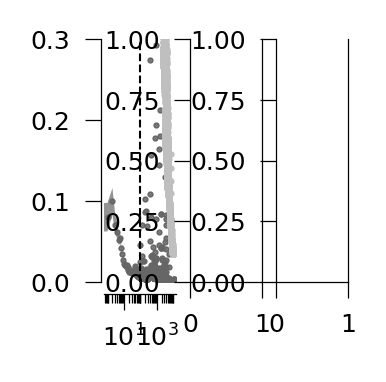

In [13]:
import matplotlib.pyplot as plt

# we rasterize, else dots increase file size by
# 6MB per plot
# takes 2 mins
YLIM_R = [0, 0.3]
YLIM_P = [0, 0.005]
N_MAJOR_TICKS = 4
SIZE = 0.5
ALPHA = 0.7
linw = 1
fig, axes = plt.subplots(1, 3, figsize=FIG_SIZE, dpi=300)

# Raw panel (8 secs) --------------------------------

# VIVO
pm = {
    "linestyle": "none",
    "marker": "o",
    "markersize": SIZE,
    "rasterized": True,
}

# 3 secs
axes[0].plot(psd_raw_mv["freq"], psd_mean_mv, label="vivo", color=COLOR_MV, **pm)
axes[0].plot(psd_raw_hv["freq"], psd_mean_hv, color=COLOR_HV, label="silico", **pm)

# confidence interval
axes[0].fill_between(
    psd_raw_mv["freq"],
    (psd_mean_mv - ci_raw_mv),
    (psd_mean_mv + ci_raw_mv),
    color=COLOR_MV,
    linewidth=0,
    alpha=ALPHA,
    rasterized=True,
)
axes[0].fill_between(
    psd_raw_hv["freq"],
    (psd_mean_hv - ci_raw_hv),
    (psd_mean_hv + ci_raw_hv),
    color=COLOR_HV,
    linewidth=0,
    alpha=ALPHA,
    rasterized=True,
)

# STATS: mark pvalues < 0.05
# x = out_raw_m["freq"][np.where(pvalues005_raw == 1)[0]]
# y = pvalues005_raw[np.where(pvalues005_raw == 1)[0]] * YLIM_R[1]
# axes[0].plot(x, y, "k.", markersize=1, rasterized=True)

# 100 Hz (LFP)
axes[0].vlines(
    x=100, ymin=YLIM_R[0], ymax=YLIM_R[1], linestyle="--", color="k", linewidth=0.5
)

# legend
axes[0].set_xscale("log")

# axes[0].set_xlabel("frequency [Hz]")
# axes[0].set_ylabel("Power ($\mu V^2$/Hz)")
axes[0].spines[["right", "top"]].set_visible(False)
axes[0].tick_params(axis="x", which="minor", colors="black")
axes[0].tick_params(axis="x", which="major", colors="black")

# show minor ticks
locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
locmin = matplotlib.ticker.LogLocator(
    base=10.0,
    subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
    numticks=N_MINOR_TICKS,
)
axes[0].tick_params(which="both")
axes[0].xaxis.set_major_locator(locmaj)
axes[0].xaxis.set_minor_locator(locmin)
axes[0].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

# disconnect axes (R style)
axes[0].spines["bottom"].set_position(("axes", -0.05))
axes[0].yaxis.set_ticks_position("left")
axes[0].spines["left"].set_position(("axes", -0.05))
axes[0].set_ylim(YLIM_R)
axes[0].set_xlim([0, SFREQ_MV / 2])

# Fit panel ************************************************************

print("Raw")

    COLOR_HV = [0.75, 0.75, 0.75] # light
    COLOR_MV = [0.4, 0.4, 0.4]
    COLOR_HS = [0.9, 0.64, 0.65] # light
    COLOR_MS = [0.9, 0.14, 0.15]    
    
power.plot_fits_all(axes[1], psd_raw_mv, psd_raw_hv, pm, linw, COLOR_HV, COLOR_MV, pm)

# Preprocessed panel ************************************************************

axes[2].plot(
    psd_pre_mv["freq"],
    psd_mean_pre_mv,
    linestyle="none",
    marker="o",
    markersize=SIZE,
    color=COLOR_MV,
    label="vivo",
    rasterized=True,
)
axes[2].plot(
    psd_pre_hv["freq"],
    psd_mean_pre_hv,
    linestyle="none",
    marker="o",
    markersize=SIZE,
    color=COLOR_HV,
    label="horvath",
    rasterized=True,
)

# confidence interval
axes[2].fill_between(
    psd_pre_mv["freq"],
    (psd_mean_pre_mv - ci_pre_mv),
    (psd_mean_pre_mv + ci_pre_mv),
    color=COLOR_MV,
    linewidth=0,
    alpha=ALPHA,
    rasterized=True,
)
axes[2].fill_between(
    psd_pre_hv["freq"],
    (psd_mean_pre_hv - ci_pre_hv),
    (psd_mean_pre_hv + ci_pre_hv),
    color=COLOR_HV,
    linewidth=0,
    alpha=ALPHA,
    rasterized=True,
)

# mark pvalues < 0.05
# x = out_prep_m["freq"][np.where(pvalues005_prep == 1)[0]]
# y = pvalues005_prep[np.where(pvalues005_prep == 1)[0]] * YLIM_P[1]
# axes[2].plot(x, y, "k.", markersize=1, rasterized=True)

# 100 Hz (LFP)
axes[2].vlines(
    x=100, ymin=YLIM_P[0], ymax=YLIM_P[1], linestyle="--", color="k", linewidth=0.5
)

# legend
axes[2].set_xscale("log")
axes[2].spines[["right", "top"]].set_visible(False)
axes[2].legend(**legend_cfg)

# show minor ticks
locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
locmin = matplotlib.ticker.LogLocator(
    base=10.0,
    subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
    numticks=N_MINOR_TICKS,
)
axes[2].tick_params(which="both")
axes[2].xaxis.set_major_locator(locmaj)
axes[2].xaxis.set_minor_locator(locmin)
axes[2].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

# disconnect x,y axes
axes[2].spines["bottom"].set_position(("axes", -0.05))
axes[2].yaxis.set_ticks_position("left")
axes[2].spines["left"].set_position(("axes", -0.05))
axes[2].set_ylim(YLIM_P)
axes[2].set_xlim([0, SFREQ_MV / 2])
axes[2].set_yticks([0, YLIM_P[1]], [0, YLIM_P[1]])

# tight
fig.tight_layout(**tight_layout_cfg)

# clear legend
axes[2].get_legend().remove()

# save figure
plt.savefig("figures/2_realism/4_power/fig2h/power_law.svg", **savefig_cfg)

#### plot layer 1

mean alpha: -0.5556155599194048
std alpha: 0.1356996994922597
n= 10
mean alpha: -0.8096595863119912
std alpha: 0.03534024581399763
n= 10
mean alpha: -0.28710996409125905
std alpha: 0.006215741716605128
n= 16
mean alpha: -0.7475027981899094
std alpha: 0.0900770612646617
n= 16
mean alpha: -0.007265342052916719
std alpha: 0.0027522695715579393
n= 16
2024-06-06 16:07:54,883 - matplotlib.legend - legend.py - _parse_legend_args - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


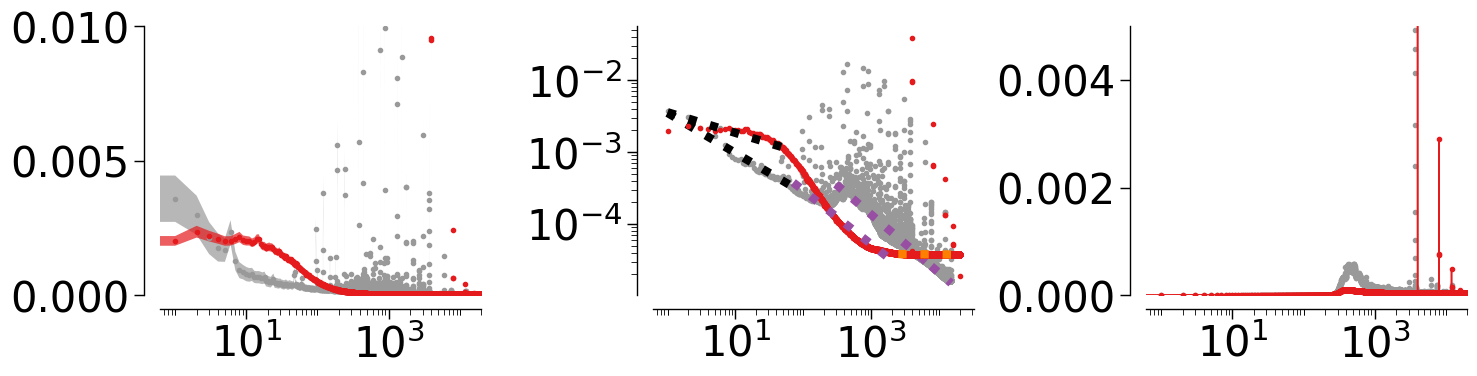

In [329]:
layer = "L1"

# compute data
(
    psd_mean_raw_vivo_L1,
    psd_mean_raw_sili_L1,
    psd_mean_prep_vivo_L1,
    psd_mean_prep_sili_L1,
    ci_raw_vivo_L1,
    ci_raw_sili_L1,
    ci_prep_vivo_L1,
    ci_prep_sili_L1,
    freq_raw_v,
    freq_raw_s,
    freq_prep_v,
    freq_prep_s,
) = get_psd_plot_mean_and_ci_for_layer(
    layer,
    site_layers_vivo,
    site_layers_sili,
    out_raw_vivo,
    out_raw_sili,
    out_prep_vivo,
    out_prep_sili,
)

# plot
axes = plot_for_layer(
    psd_mean_raw_vivo_L1,
    psd_mean_raw_sili_L1,
    psd_mean_prep_vivo_L1,
    psd_mean_prep_sili_L1,
    ci_raw_vivo_L1,
    ci_prep_vivo_L1,
    ci_raw_sili_L1,
    ci_prep_sili_L1,
    freq_raw_v,
    freq_raw_s,
    freq_prep_v,
    freq_prep_s,
    out_raw_vivo,
    out_raw_sili,
    out_prep_vivo,
    out_prep_sili,
    site_layers_vivo,
    site_layers_sili,
    layer,
)

# save
# plt.savefig("figures/2_realism/4_power/svg/marques/psd_ly1.svg", **savefig_cfg)

#### plot layer 2/3

mean alpha: -0.5998667176554915
std alpha: 0.19796739130417393
n= 42
mean alpha: -0.7256251953806686
std alpha: 0.11228470886903635
n= 42
mean alpha: -0.24830159585208794
std alpha: 0.011689157086739541
n= 47
mean alpha: -0.9437083581522038
std alpha: 0.11028831895818389
n= 47
mean alpha: -0.008522083046159085
std alpha: 0.0027648991567844625
n= 47
2024-06-06 16:17:46,996 - matplotlib.legend - legend.py - _parse_legend_args - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


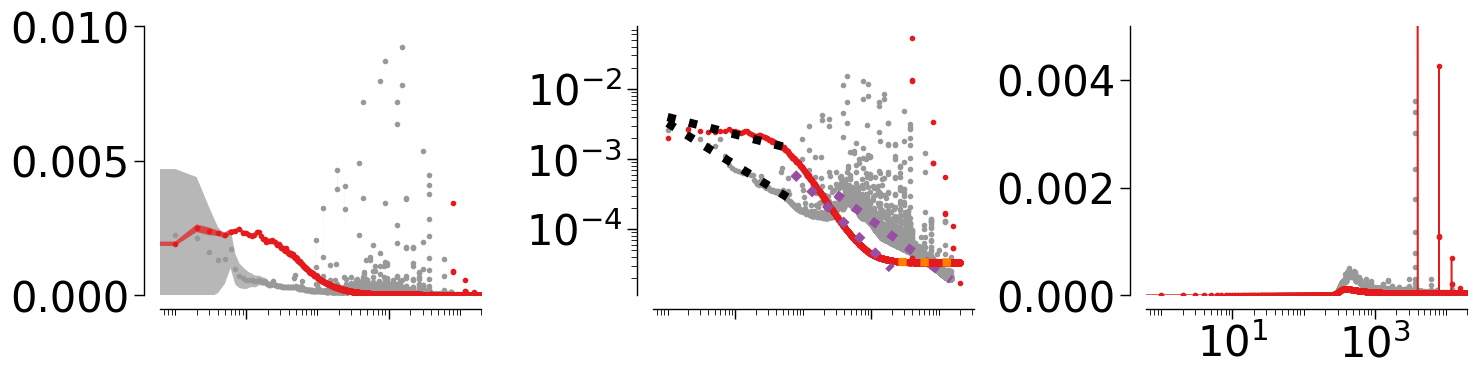

In [331]:
layer = "L2_3"


# compute data
(
    psd_mean_raw_vivo_L2,
    psd_mean_raw_sili_L2,
    psd_mean_prep_vivo_L2,
    psd_mean_prep_sili_L2,
    ci_raw_vivo_L2,
    ci_raw_sili_L2,
    ci_prep_vivo_L2,
    ci_prep_sili_L2,
    freq_raw_v,
    freq_raw_s,
    freq_prep_v,
    freq_prep_s,
) = get_psd_plot_mean_and_ci_for_layer(
    layer,
    site_layers_vivo,
    site_layers_sili,
    out_raw_vivo,
    out_raw_sili,
    out_prep_vivo,
    out_prep_sili,
)

# plot
axes = plot_for_layer(
    psd_mean_raw_vivo_L2,
    psd_mean_raw_sili_L2,
    psd_mean_prep_vivo_L2,
    psd_mean_prep_sili_L2,
    ci_raw_vivo_L2,
    ci_prep_vivo_L2,
    ci_raw_sili_L2,
    ci_prep_sili_L2,
    freq_raw_v,
    freq_raw_s,
    freq_prep_v,
    freq_prep_s,
    out_raw_vivo,
    out_raw_sili,
    out_prep_vivo,
    out_prep_sili,
    site_layers_vivo,
    site_layers_sili,
    layer,
)

axes[0].set_xticklabels([])
axes[1].set_xticklabels([])

# save
# plt.savefig("figures/2_realism/4_power/svg/marques/psd_l23.svg", **savefig_cfg)

#### plot layer 4

mean alpha: -0.4761065387162335
std alpha: 0.15653039976948066
n= 34
mean alpha: -0.659226882950345
std alpha: 0.059554786721747736
n= 34
mean alpha: -0.2649585175428812
std alpha: 0.0065726364446417945
n= 19
mean alpha: -1.335018523683255
std alpha: 0.05950858021662043
n= 19
mean alpha: -0.01757196330948316
std alpha: 0.007108492976624111
n= 19
2024-06-06 16:17:24,445 - matplotlib.legend - legend.py - _parse_legend_args - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


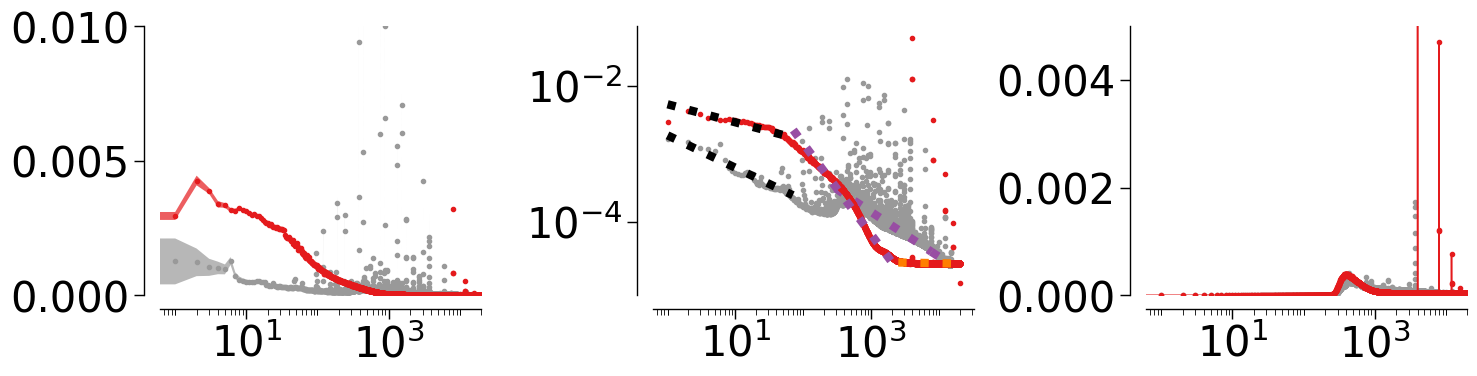

In [330]:
layer = "L4"

# compute data
(
    psd_mean_raw_vivo_L4,
    psd_mean_raw_sili_L4,
    psd_mean_prep_vivo_L4,
    psd_mean_prep_sili_L4,
    ci_raw_vivo_L4,
    ci_raw_sili_L4,
    ci_prep_vivo_L4,
    ci_prep_sili_L4,
    freq_raw_v,
    freq_raw_s,
    freq_prep_v,
    freq_prep_s,
) = get_psd_plot_mean_and_ci_for_layer(
    layer,
    site_layers_vivo,
    site_layers_sili,
    out_raw_vivo,
    out_raw_sili,
    out_prep_vivo,
    out_prep_sili,
)

# plot
axes = plot_for_layer(
    psd_mean_raw_vivo_L4,
    psd_mean_raw_sili_L4,
    psd_mean_prep_vivo_L4,
    psd_mean_prep_sili_L4,
    ci_raw_vivo_L4,
    ci_prep_vivo_L4,
    ci_raw_sili_L4,
    ci_prep_sili_L4,
    freq_raw_v,
    freq_raw_s,
    freq_prep_v,
    freq_prep_s,
    out_raw_vivo,
    out_raw_sili,
    out_prep_vivo,
    out_prep_sili,
    site_layers_vivo,
    site_layers_sili,
    layer,
)

# save
# plt.savefig("figures/2_realism/4_power/svg/marques/psd_l4.svg", **savefig_cfg)

#### plot layer 5

mean alpha: -0.49125881316994596
std alpha: 0.11974942654253275
n= 42
mean alpha: -0.9076647016118654
std alpha: 0.1448064624629045
n= 42
mean alpha: -0.22520901289586776
std alpha: 0.01497909792630687
n= 52
mean alpha: -1.4304447691879385
std alpha: 0.08393813765191344
n= 52
mean alpha: -0.04924678832225652
std alpha: 0.03390135209594023
n= 52
mean alpha: 0.31888099307276624
std alpha: 0.11895032227182545
n= 384
mean alpha: -0.9636730776125612
std alpha: 0.1199238514860082
n= 384
2024-06-07 09:53:47,963 - matplotlib.legend - legend.py - _parse_legend_args - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


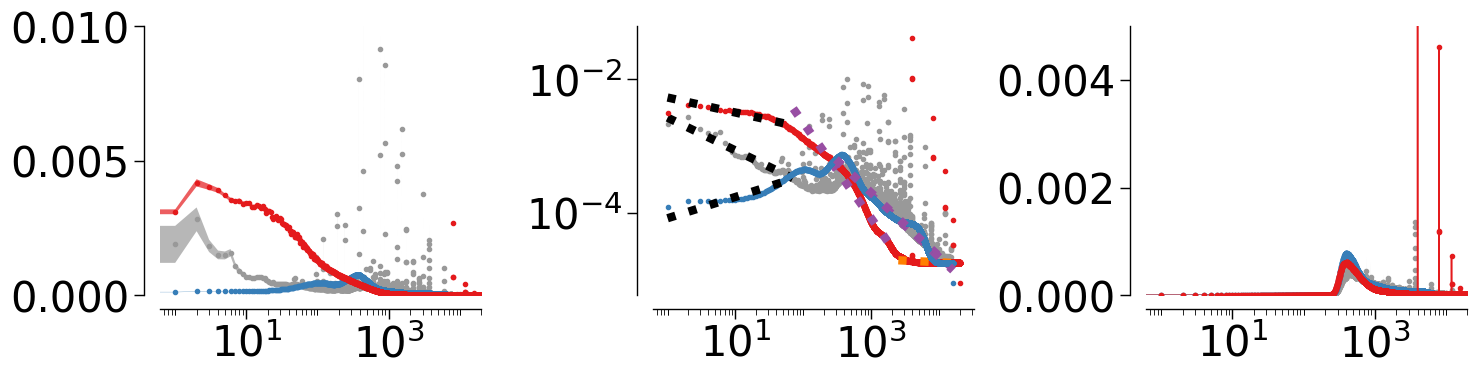

In [19]:
(
    psd_mean_raw_vivo,
    psd_mean_raw_sili,
    psd_mean_raw_b,
    psd_mean_prep_vivo,
    psd_mean_prep_sili,
    psd_mean_prep_b,
    ci_raw_vivo,
    ci_raw_sili,
    ci_raw_b,
    ci_prep_vivo,
    ci_prep_sili,
    ci_prep_b,
    freq_raw_v,
    freq_raw_s,
    freq_raw_b,
    freq_prep_v,
    freq_prep_s,
    freq_prep_b,
) = get_psd_plot_mean_and_ci_for_layer_5(
    site_layers_vivo,
    site_layers_sili,
    out_raw_vivo,
    out_raw_sili,
    out_raw_b,
    out_prep_vivo,
    out_prep_sili,
    out_prep_b,
)

# plot
plot_for_layer_5(
    psd_mean_raw_vivo,
    psd_mean_raw_sili,
    psd_mean_raw_b,
    psd_mean_prep_vivo,
    psd_mean_prep_sili,
    psd_mean_prep_b,
    ci_raw_vivo,
    ci_raw_sili,
    ci_raw_b,
    ci_prep_vivo,
    ci_prep_sili,
    ci_prep_b,
    freq_raw_v,
    freq_raw_s,
    freq_raw_b,
    freq_prep_v,
    freq_prep_s,
    freq_prep_b,
    out_raw_vivo,
    out_raw_sili,
    out_raw_b,
    site_layers_vivo,
    site_layers_sili,
)

plt.savefig("figures/2_realism/4_power/svg/marques/psd_ly5.svg", **savefig_cfg)

#### plot layer 6

In [333]:
layer = "L6"

# compute data
(
    psd_mean_raw_vivo_L2,
    psd_mean_raw_sili_L2,
    psd_mean_prep_vivo_L2,
    psd_mean_prep_sili_L2,
    ci_raw_vivo_L2,
    ci_raw_sili_L2,
    ci_prep_vivo_L2,
    ci_prep_sili_L2,
    freq_raw_v,
    freq_raw_s,
    freq_prep_v,
    freq_prep_s,
) = get_psd_plot_mean_and_ci_for_layer(
    layer,
    site_layers_vivo,
    site_layers_sili,
    out_raw_vivo,
    out_raw_sili,
    out_prep_vivo,
    out_prep_sili,
)

# plot
axes = plot_for_layer(
    psd_mean_raw_vivo_L2,
    psd_mean_raw_sili_L2,
    psd_mean_prep_vivo_L2,
    psd_mean_prep_sili_L2,
    ci_raw_vivo_L2,
    ci_prep_vivo_L2,
    ci_raw_sili_L2,
    ci_prep_sili_L2,
    freq_raw_v,
    freq_raw_s,
    freq_prep_v,
    freq_prep_s,
    out_raw_vivo,
    out_raw_sili,
    out_prep_vivo,
    out_prep_sili,
    site_layers_vivo,
    site_layers_sili,
    layer,
)

# save
plt.savefig("figures/2_realism/4_power/svg/marques/psd_ly6.svg", **savefig_cfg)

mean alpha: -0.6440507429442404
std alpha: 0.08734803962708894
n= 98
mean alpha: -1.034885528055395
std alpha: 0.2593894417525664
n= 98
mean alpha: -0.24130701707940883
std alpha: 0.029720703352530103
n= 68
mean alpha: -0.6698522601592221
std alpha: 0.22576367484053744
n= 68
mean alpha: -0.011655805915900206
std alpha: 0.007376099285893279
n= 68
2024-06-06 16:26:46,087 - matplotlib.legend - legend.py - _parse_legend_args - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


# references

see plot of known frequency scaling properties of LFP (http://www.scholarpedia.org/article/File:Diffusion-LFP.jpg)
